In [73]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import optuna
import joblib

import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from OptunaXGB import objective
from PreprocessingFunction import build_preprocessor

from collections import Counter


RANDOM_STATE = 42

In [74]:
# Load preprocessed data
df_cleaned = pd.read_csv("../data/preprocessed_data.csv")

In [75]:
# Split features and target variable
X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

---
Preprocessing
---

In [76]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)

In [77]:
preprocessor = build_preprocessor(X_train)
ratio = Counter(y_train)[0] / Counter(y_train)[1]

---
Optuna
---

[I 2025-12-31 15:20:42,638] A new study created in memory with name: no-name-611f76d5-cfcc-437a-bced-be66c6980825
[I 2025-12-31 15:20:44,913] Trial 0 finished with value: 0.9195784788725152 and parameters: {'n_estimators': 654, 'max_depth': 5, 'learning_rate': 0.14582090859263136, 'subsample': 0.8923432084018145}. Best is trial 0 with value: 0.9195784788725152.
[I 2025-12-31 15:20:48,217] Trial 1 finished with value: 0.9232618909730762 and parameters: {'n_estimators': 570, 'max_depth': 7, 'learning_rate': 0.07474610990314748, 'subsample': 0.9260481433078338}. Best is trial 1 with value: 0.9232618909730762.
[I 2025-12-31 15:20:53,440] Trial 2 finished with value: 0.9208173170074231 and parameters: {'n_estimators': 547, 'max_depth': 7, 'learning_rate': 0.07888641277832105, 'subsample': 0.7636151862086102}. Best is trial 1 with value: 0.9232618909730762.
[I 2025-12-31 15:20:55,434] Trial 3 finished with value: 0.9307452864787809 and parameters: {'n_estimators': 668, 'max_depth': 3, 'learn


--- ÉVALUATION OPTUNA ---
Accuracy: 0.8936666666666667
Precision: 0.7864476386036962
Recall: 0.6404682274247492
F1-score: 0.7059907834101382
AUC: 0.9328559116009791

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.79      0.64      0.71       598

    accuracy                           0.89      3000
   macro avg       0.85      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



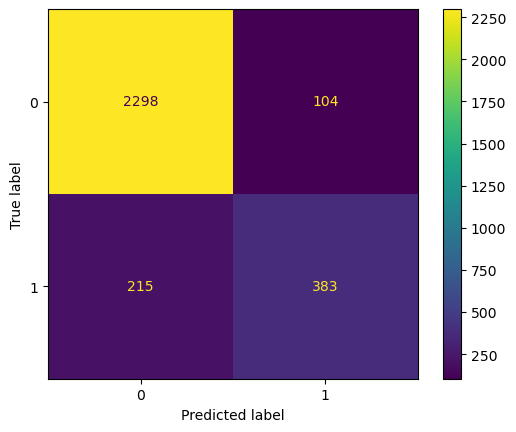

In [78]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "scale_pos_weight": ratio,
        "eval_metric": "logloss",
        "random_state": 42
    }
    model = XGBClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_opt_xgb = XGBClassifier(**study.best_params, random_state=42)
optuna_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_opt_xgb)])
optuna_pipe.fit(X_train, y_train)

print("\n--- ÉVALUATION OPTUNA ---")
evaluate_model(y_test, optuna_pipe.predict(X_test), optuna_pipe.predict_proba(X_test)[:, 1])


---
GridSearchCV
---


--- ÉVALUATION GRIDSEARCH ---
Accuracy: 0.896
Precision: 0.8055555555555556
Recall: 0.6304347826086957
F1-score: 0.7073170731707317
AUC: 0.934072150019911

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.81      0.63      0.71       598

    accuracy                           0.90      3000
   macro avg       0.86      0.80      0.82      3000
weighted avg       0.89      0.90      0.89      3000



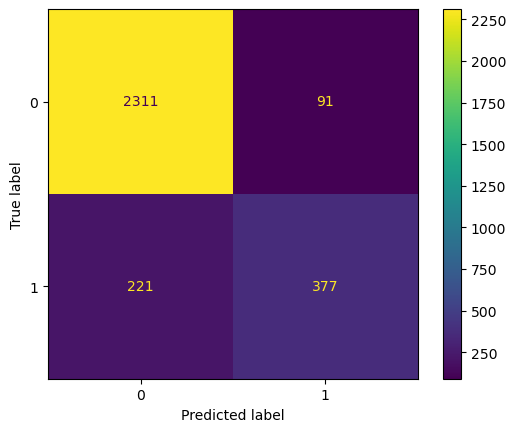

In [79]:
param_grid = {
    "classifier__n_estimators": [study.best_params["n_estimators"] - 50, study.best_params["n_estimators"] + 50],
    "classifier__max_depth": [study.best_params["max_depth"] - 1, study.best_params["max_depth"] + 1]
}

grid = GridSearchCV(optuna_pipe, param_grid, scoring="roc_auc", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n--- ÉVALUATION GRIDSEARCH ---")
evaluate_model(y_test, grid.predict(X_test), grid.predict_proba(X_test)[:, 1])

---
Class Churn Imbalance 
---


>>> ANALYSE : Sans Équilibre
Accuracy: 0.896
Precision: 0.8055555555555556
Recall: 0.6304347826086957
F1-score: 0.7073170731707317
AUC: 0.934072150019911

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.81      0.63      0.71       598

    accuracy                           0.90      3000
   macro avg       0.86      0.80      0.82      3000
weighted avg       0.89      0.90      0.89      3000



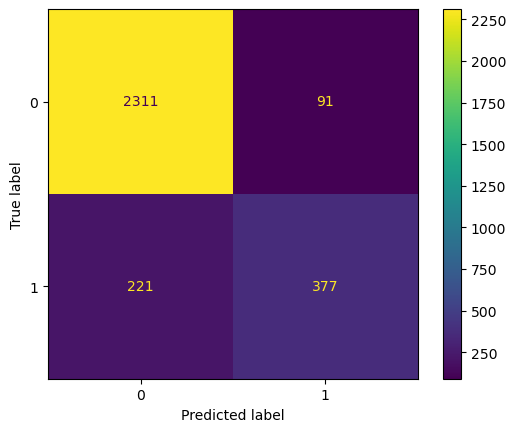


>>> ANALYSE : Weight Only
Accuracy: 0.8626666666666667
Precision: 0.611244019138756
Recall: 0.8545150501672241
F1-score: 0.7126917712691772
AUC: 0.9340502201342804

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      2402
           1       0.61      0.85      0.71       598

    accuracy                           0.86      3000
   macro avg       0.79      0.86      0.81      3000
weighted avg       0.89      0.86      0.87      3000



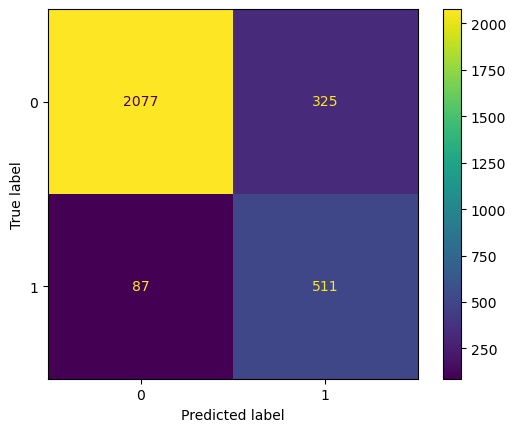


>>> ANALYSE : SMOTE Only
Accuracy: 0.8733333333333333
Precision: 0.6445623342175066
Recall: 0.8127090301003345
F1-score: 0.7189349112426036
AUC: 0.930727320321137

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2402
           1       0.64      0.81      0.72       598

    accuracy                           0.87      3000
   macro avg       0.80      0.85      0.82      3000
weighted avg       0.89      0.87      0.88      3000



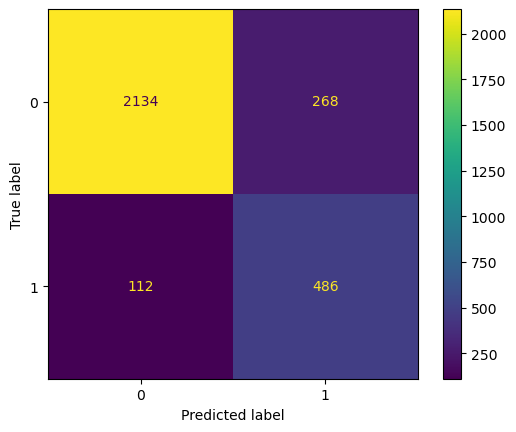


>>> ANALYSE : SMOTE + Weight
Accuracy: 0.783
Precision: 0.4771748492678725
Recall: 0.9264214046822743
F1-score: 0.6299033541785105
AUC: 0.930314133428386

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      2402
           1       0.48      0.93      0.63       598

    accuracy                           0.78      3000
   macro avg       0.73      0.84      0.74      3000
weighted avg       0.88      0.78      0.80      3000



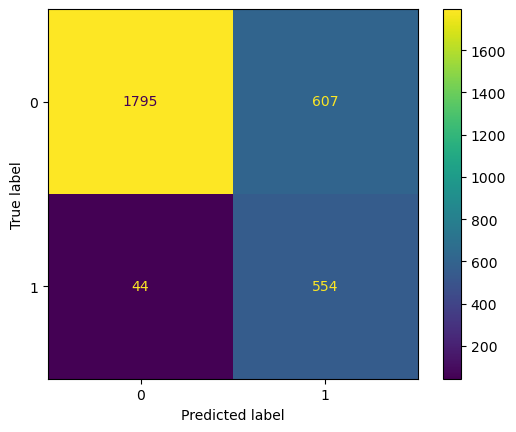

In [80]:

# ---  CHOIX DU MEILLEUR ET ANALYSE DÉSÉQUILIBRE ---
auc_opt = roc_auc_score(y_test, optuna_pipe.predict_proba(X_test)[:, 1])
auc_gs = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])

best_params_moteur = grid.best_estimator_.named_steps['classifier'].get_params() if auc_gs >= auc_opt else best_opt_xgb.get_params()
best_params_moteur = {k: v for k, v in best_params_moteur.items() if k not in ['scale_pos_weight']}

strategies = {
    "Sans Équilibre": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "Weight Only": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))]),
    "SMOTE Only": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "SMOTE + Weight": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))])
}

final_auc = {}
for name, pipe in strategies.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    final_auc[name] = roc_auc_score(y_test, y_prob)
    print(f"\n>>> ANALYSE : {name}")
    evaluate_model(y_test, y_pred, y_prob)

---
Selection the best model
---

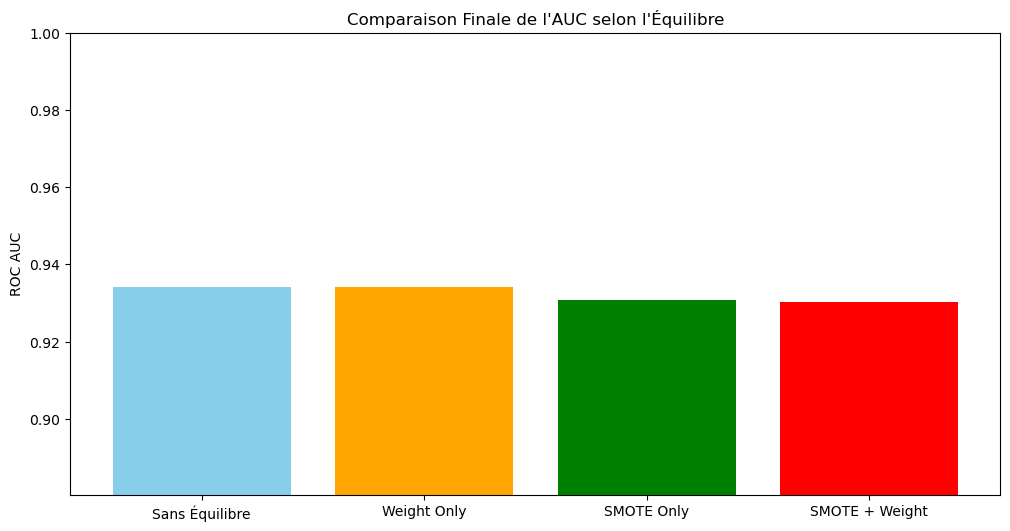

In [81]:
# ---  VIZ & SAUVEGARDE ---
plt.figure(figsize=(12, 6))
plt.bar(final_auc.keys(), final_auc.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(min(final_auc.values()) - 0.05, 1.0)
plt.title("Comparaison Finale de l'AUC selon l'Équilibre")
plt.ylabel("ROC AUC")
plt.show()

In [82]:
best_key = max(final_auc, key=final_auc.get)
joblib.dump(strategies[best_key], '../models/best_model.pkl')

['../models/best_model.pkl']